<a href="https://colab.research.google.com/github/cchen744/uhi-extreme-heat-response/blob/main/notebooks/02_uhi_extreme_heat_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In notebook 01, we have finished data preprocessing and output cleaned dataset containing urban temp, rural ring temp, as well as extreme heat.
In this notebook, we will use Phoenix, Houston, and Chicago as sample cities to test whether extreme heat would contribute to the change in UHI.


In [ ]:
!git init
!git remote add origin https://github.com/cchen744/uhi-extreme-heat-response.git
!git pull origin main --allow-unrelated-histories
!git status

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following block of code will use a set of extreme heat definitions to examine extreme weather frequency on each city, in general we have extreme heat definition of:
- Percentile: 85, 90, 92.5, 95
- Absolute Threshold (Celsius): 22, 24, 26, 30, 35


In [20]:
for filename in os.listdir('/content/data/cities'):
  current_df = pd.read_csv('/content/data/cities/'+filename)
  print('\n'+filename.split('_')[0])

  current_df['date'] = current_df['date'].astype(str)
  current_df['date'] = pd.to_datetime(current_df['date'], errors='coerce', format='mixed')

  current_df.dropna(subset=['date'], inplace=True)

  # Convert 'LST_urb' to numeric, coercing errors to NaN
  # This step is crucial because np.percentile expects numeric data.
  current_df['LST_urb'] = pd.to_numeric(current_df['LST_urb'], errors='coerce')

  # Drop rows where 'LST_urb' is NaN, as np.percentile needs valid numbers.
  # Alternatively, NaNs could be handled by imputation or other methods,
  # but for percentile calculation, dropping is a common approach if missing values are few.
  current_df.dropna(subset=['LST_urb'], inplace=True)

  sorted_current_df = current_df.sort_values("date").copy()

  # 1) percentile only (no consecutive)
  for p in [85, 90, 92.5, 95]:
    thr = np.percentile(sorted_current_df["LST_urb"], p)
    n = (sorted_current_df["LST_urb"] >= thr).sum()
    print("percentile", p, "days:", n)

  # 2) absolute thresholds
  for t in [22, 24, 26, 30, 35]:
    n = (sorted_current_df["LST_urb"] >= t).sum()
    print("abs >=", t, "C days:", n)



Chicago
percentile 85 days: 10
percentile 90 days: 7
percentile 92.5 days: 5
percentile 95 days: 4
abs >= 22 C days: 0
abs >= 24 C days: 0
abs >= 26 C days: 0
abs >= 30 C days: 0
abs >= 35 C days: 0

Phoenix
percentile 85 days: 253
percentile 90 days: 169
percentile 92.5 days: 127
percentile 95 days: 85
abs >= 22 C days: 548
abs >= 24 C days: 418
abs >= 26 C days: 259
abs >= 30 C days: 34
abs >= 35 C days: 16

Houston
percentile 85 days: 199
percentile 90 days: 133
percentile 92.5 days: 100
percentile 95 days: 67
abs >= 22 C days: 459
abs >= 24 C days: 227
abs >= 26 C days: 34
abs >= 30 C days: 16
abs >= 35 C days: 16


**Interpretation**

1. **Chicago,IL**: Under percentile-based definitions, Chicago yields too few extreme heat days to support a distributional comparison of SUHI. *So now Chicago will be excluded due to insufficient extreme-day samples*
2. **Phoenix,AZ**: Phoenix's extreme heat definition is statistically stable under multiple operationalizzations
3. **Houston,TX**: definition under percentile is applicable, while definition under high absolute threshold performs down.

**Thus, we will take Phoenix and Houston as response test sample cities, while take Chicago as the baseline city**

## SUHI & Extreme Heat Correlation Check

By using boxplot, we expect to see if the under extreme heat, the distribution of SUHI would be different.

Index(['LST_rur', 'LST_urb', 'date', 'rural_n', 'urban_n', 'SUHI',
       'is_extreme'],
      dtype='object')


/tmp/ipython-input-1183121567.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


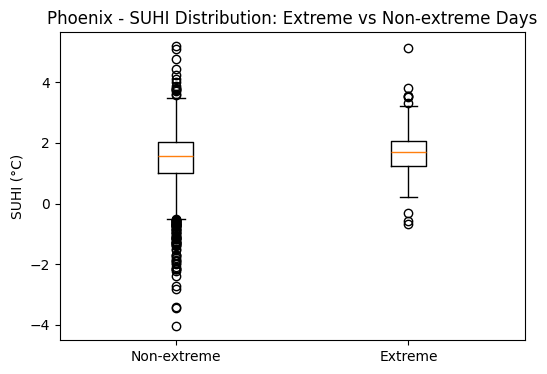

Mean of Extreme Days: 1.6880631191645132
Mean of Non-Extreme Days: 1.4428379244753669
Mann–Whitney test u, p: 222791.0 0.0016852276332208534


In [43]:
# Boxplot - Phoenix
phoenix_df = pd.read_csv('/content/data/cities/Phoenix_daily_suhi.csv')
print(phoenix_df.columns)
phoenix_df.head()


suhi_non = phoenix_df.loc[phoenix_df["is_extreme"] == 0, "SUHI"]
suhi_ext = phoenix_df.loc[phoenix_df["is_extreme"] == 1, "SUHI"]

plt.figure(figsize=(6,4))
plt.boxplot(
    [suhi_non, suhi_ext],
    labels=["Non-extreme", "Extreme"],
    showfliers=True
)
plt.ylabel("SUHI (°C)")
plt.title("Phoenix - SUHI Distribution: Extreme vs Non-extreme Days")
plt.show()

mean_ext = suhi_ext.mean()
mean_non = suhi_non.mean()
delta = mean_ext - mean_non
print("Mean of Extreme Days:", mean_ext)
print("Mean of Non-Extreme Days:", mean_non)

# Mann–Whitney test: check statistical significance
u, p = mannwhitneyu(
    suhi_ext,
    suhi_non,
    alternative="greater"
)

print("Mann–Whitney test u, p:", float(u), float(p))


Index(['LST_rur', 'LST_urb', 'date', 'rural_n', 'urban_n', 'SUHI',
       'is_extreme'],
      dtype='object')


/tmp/ipython-input-4115205854.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


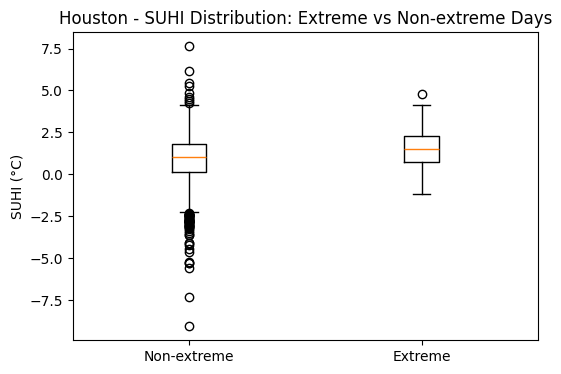

Mean of Extreme Days: 1.5289579358226568
Mean of Non-Extreme Days: 0.8322385123471451
Mann–Whitney test u, p: 193822.0 6.544556197290829e-10


In [44]:
# Boxplot - Houston
houston_df = pd.read_csv('/content/data/cities/Houston_daily_suhi.csv')
print(houston_df.columns)
houston_df.head()


suhi_non = houston_df.loc[houston_df["is_extreme"] == 0, "SUHI"]
suhi_ext = houston_df.loc[houston_df["is_extreme"] == 1, "SUHI"]

plt.figure(figsize=(6,4))
plt.boxplot(
    [suhi_non, suhi_ext],
    labels=["Non-extreme", "Extreme"],
    showfliers=True
)
plt.ylabel("SUHI (°C)")
plt.title("Houston - SUHI Distribution: Extreme vs Non-extreme Days")
plt.show()

mean_ext = suhi_ext.mean()
mean_non = suhi_non.mean()
delta = mean_ext - mean_non
print("Mean of Extreme Days:", mean_ext)
print("Mean of Non-Extreme Days:", mean_non)

# Mann–Whitney test: check statistical significance
u, p = mannwhitneyu(
    suhi_ext,
    suhi_non,
    alternative="greater"
)

print("Mann–Whitney test u, p:", float(u), float(p))


## Early findings
- In Phoenix, SUHI during extreme heat days is on average approximately 0.25 °C higher than during non-extreme days. While the difference is statistically significant (Mann–Whitney U test, p < 0.01), the magnitude of the increase is modest.
- Using the same method, it is shown that Houston exhibits a pronounced and statistically significant SUHI enhancement (+ 0.7 °C) during extreme heat days.